In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy as hp
from healpy.visufunc import projplot
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, angular_separation, Angle
import astropy.units as u
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
import dipole

### pars

In [5]:
nside = 64
npix = hp.nside2npix(nside)

### S21 fiducial sample

In [4]:
# Catwise AGNs
catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits',
                      catname='catwise_agns', mag='w1', load_init=False)

In [11]:
# load sample and smoothed map
d = SecrestDipole(blim=30, save_tag='', maglim=16.4, **catwise_kwargs)
map_ = np.full(npix, np.nan)
tab = d.load_hpxelatcorr()
map_[tab['hpidx']] = tab['elatdenscorr']
t = d.load_smoothed_map()
smoothed_map = np.full_like(map_, np.nan)
smoothed_map[t['hpidx']] = t['smoothed']

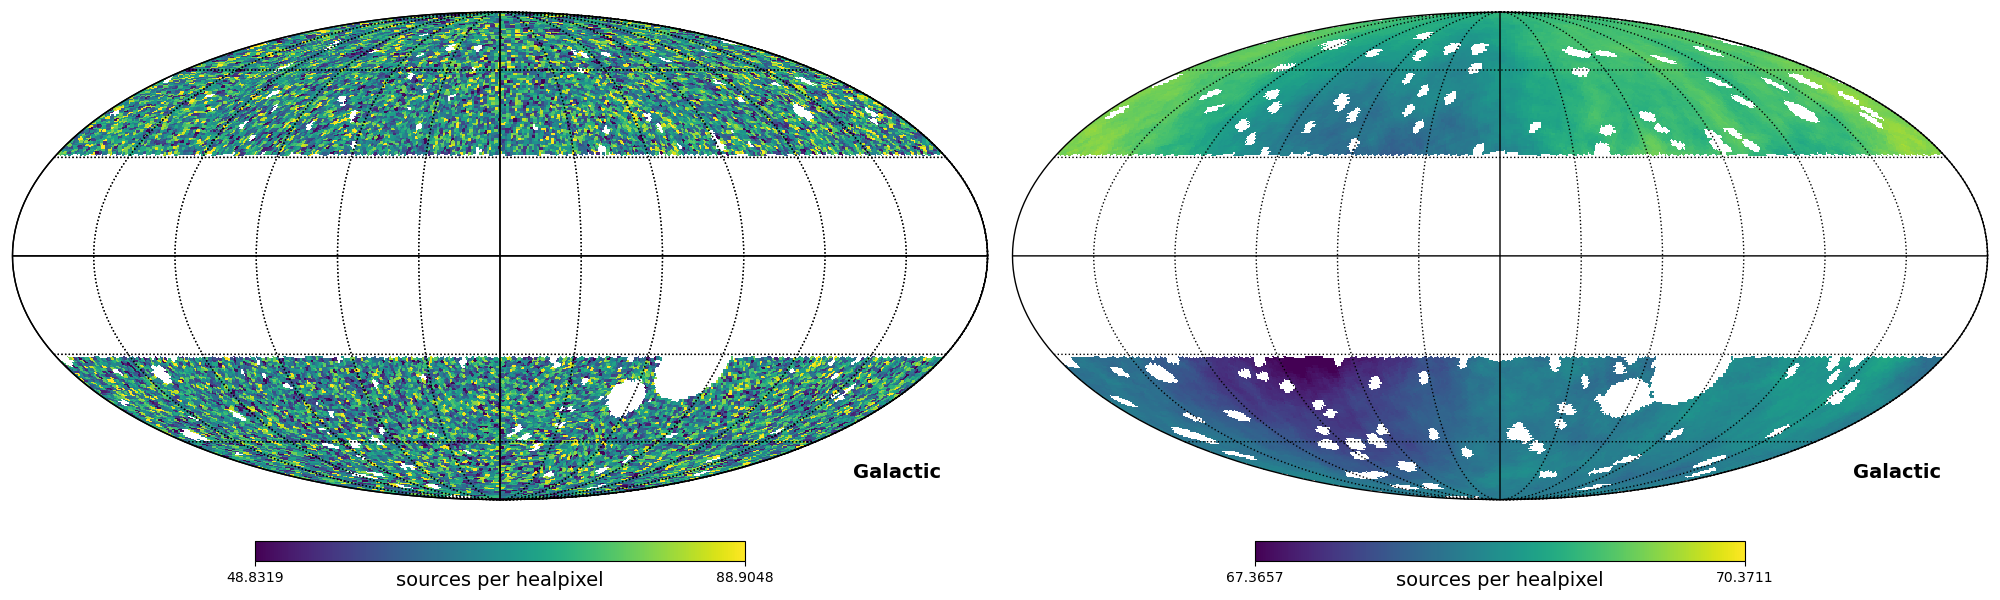

In [19]:
# plot
mean, std = np.nanmean(map_), np.nanstd(map_)

fig = plt.figure(figsize=(20,8))
kwargs = dict(coord=['C','G'], title='', unit='sources per healpixel', badcolor='w')
hp.mollview(map_, sub=(1,2,1), min=mean-2*std, max=mean+2*std, **kwargs)
hp.graticule()
hp.mollview(smoothed_map, min=mean-0.15*std, max=mean+0.15*std, sub=(1,2,2), **kwargs)
hp.graticule()
# hp.projplot(np.linspace(0, np.pi, 20), np.zeros(20), color='k', ls='-', marker='.', sub=(1,2,1))
# tools.plot_marker(cmb_dir.l.deg, cmb_dir.b.deg, c='k', marker='*', ms=9)
# tools.plot_marker(dipoles_bcut[ifid][1].l.deg, dipoles_bcut[ifid][1].b.deg, c='w', mec='k', lw=0.5, marker='*', ms=10)